# Qdrant & Text Data

![qdrant](img/crab_nlp.png)

This tutorial will show you how to use Qdrant to develop a semantic search service. At its core, this service will harness Natural Language Processing (NLP) methods and use Qdrant's API to store, search, and manage vectors with an additional payload.

## Table of Contents

1. Learning Outcomes
2. Overview
3. Prerequisites
4. Basic concepts
    - Initial setup
    - Examine the dataset
    - Tokenize and embed data
5. Semantic Search with Qdrant
6. Recommendations API
7. Conclusion
8. Resources

## 1. Learning outcomes

By the end of this tutorial, you will be able to
- Generate embeddings from text data.
- Create collections of vectors using Qdrant.
- Conduct semantic search over a corpus of documents using Qdrant.
- Provide recommendations with Qdrant.

## 2. Overview

Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on the interaction between computers and human language. It involves teaching computers to understand, interpret, and generate human language in a way that is both meaningful and useful. NLP techniques can help us with tasks such as text classification, named entity recognition, sentiment analysis, and language generation.

Vector databases specialize in storing and querying high-dimensional vectors. In the context of NLP, vectors are numerical representations of words, sentences, or documents that capture their semantic meaning. These vector representations, often referred to as word embeddings or document embeddings, transform textual data into a numerical format that machines can easily process and analyze.

Vector databases serve as efficient storage systems for these vector representations, allowing for fast and accurate similarity searches. They enable users to find similar words, sentences, or documents based on their semantic meaning rather than relying solely on exact matches or keywords. By organizing vectors in a way that facilitates quick retrieval and comparison, Vector databases are instrumental in powering various NLP applications, including information retrieval, recommendation systems, semantic search, and content clustering.

NLP and vector databases are connected through vector representations in NLP tasks. Vector representations enable NLP algorithms to understand the contextual relationships and semantic meaning of textual data. By leveraging Vector Databases, NLP systems can efficiently store and retrieve these vector representations, making it easier to process and analyze large volumes of textual data.

Throughout this tutorial, we will delve deeper into the fundamentals of NLP and Vector Databases. You will learn how to create embeddings for a sample dataset of newspaper articles via transformers. After that, you will use Qdrant to store, search and recommend best matches for a chosen newspaper article.

## 3. Prerequisites

To get started, use the latest Qdrant Docker image: `docker pull qdrant/qdrant`.

Next, initialize Qdrant with:

```sh
docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

In [ ]:
# install packages
%pip install qdrant-client transformers datasets torch fastembed matplotlib

## 4. Basic concepts

You might have heard of models like [GPT-4](https://openai.com/product/gpt-4), [Codex](https://openai.com/blog/openai-codex), and [PaLM-2](https://ai.google/discover/palm2) which are powering incredible tools such as [ChatGPT](https://openai.com/blog/chatgpt), [GitHub Copilot](https://github.com/features/copilot), and [Bard](https://bard.google.com/?hl=en), respectively. These three models are part of a family of deep learning architectures called [transformers](https://arxiv.org/abs/1706.03762). Transformers are known for their ability to learn long-range dependencies between words in a sentence. This ability to learn from text makes them well-suited for tasks such as machine translation, text summarization, and question answering. The transformers architecture has been incredibly influential in the field of machine learning, and one of the tools at the heart of this is the [`transformers`](https://huggingface.co/docs/transformers/index) library.

Transformer models work by using a technique called attention, which allows them to focus on different parts of a sentence when making predictions. For example, if you are trying to translate a sentence from English to Spanish, the transformer model will use attention to focus on the words in the English sentence that are most important for the translation into Spanish.

One analogy that can be used to explain transformer models is to think of them as a group of people who are trying to solve a puzzle. Each person in the group is given a different piece of the puzzle, and they need to work together to figure out how the pieces fit together. The transformer model is like the group of people, and the attention mechanism is like the way that the people in the group communicate with each other.

Transformers are essential to this tutorial. Your initial task is to 1) load sample data, 2) transform it and 3) create embeddings. You will then store the embeddings 4) in the Qdrant vector database and 5) retrieve the data using a recommendation system.

### 4.1 Initial setup

In this tutorial, you will create a newspaper article recommendation system. When the user chooses an article, the system will suggest other articles that are similar.

You will use the **AG News** [sample data set from HuggingFace](https://huggingface.co/datasets/ag_news):

> "AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html"

### 4.2 Load sample dataset

Use HuggingFace's [`datasets`](https://huggingface.co/docs/datasets/index) library to download the dataset and load it into your session. This library is quick, efficient and will allow you to manipulate unstructured data in other ways.

The `load_dataset` function directly downloads the dataset from the [HuggingFace Data Hub](https://huggingface.co/datasets) to your local machine.

In [1]:
from datasets import load_dataset

Indicate that you want to **split** the dataset into a `train` set only. This avoids creating partitions.

In [2]:
dataset = load_dataset("ag_news", split="train")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

### 4.3 Examine the dataset

Now that we have loaded the dataset, let's look at some sample articles:

In [3]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1
Blast Kills Man at Chechen Polling Station OISKHARA, Russia - Against a backdrop of war and squalor, Chechens voted Sunday for a replacement for their assassinated president in a vote the Kremlin hopes will bring some stability to the violence-torn region. A man was killed when he attempted to blow up a polling station...

Sample 2
Robin makes rare Christmas visit A rare species of robin settles in for its first winter in Scotland after being spotted on a reserve in Aberdeenshire.

Sample 3
Dravid, Gambhir blast Bangladeshi bowlers Gautam Gambhir scored a half century in his second consecutive innings after India suffered an early setback on the first day of the second and final cricket Test against Bangladesh at Chittagong today.

Sample 4
Tennis: Flying Finn Nieminen knocks off Nalbandian for third semi &lt;b&gt;...&lt;/b&gt; BEIJING : Flying Finn Jarkko Nieminen soared into his third semi-final of the season, stunning third seed David Nalbandian 6-2, 2-6, 6-2 at the 500,000

You can switch to a pandas dataframe by using the method `.to_pandas()`. This can come in handy when you want to manipulate and plot the data.

Here you will extract the class names of news articles and plot the frequency with which they appear:

In [4]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}

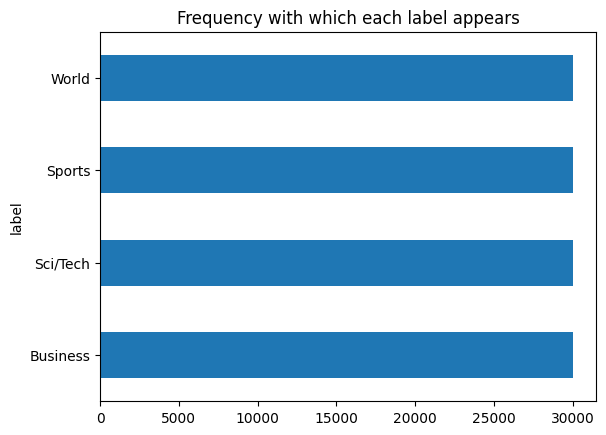

In [5]:
(
    dataset.select_columns('label')
           .to_pandas()
           .astype(str)['label']
           .map(id2label)
           .value_counts()
           .plot(kind="barh", title="Frequency with which each label appears")
);

As you can see, the dataset is well balanced.

What if you want to know the average length of text per each class label?

Write a function for this and map to all of the elements in the dataset.
`'length_of_text'` will be the new column in the dataset.

In [6]:
def get_length_of_text(example):
    example['length_of_text'] = len(example['text'])
    return example

dataset = dataset.map(get_length_of_text)
dataset[:10]['length_of_text']

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

[144, 266, 232, 256, 234, 239, 215, 252, 414, 147]

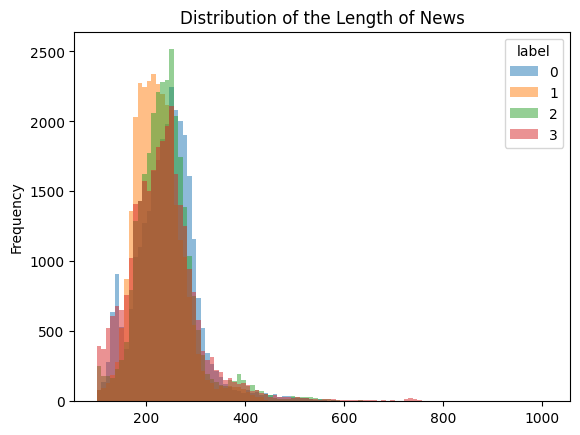

In [7]:
(
    dataset.select_columns(["label", "length_of_text"])
           .to_pandas()
           .pivot(columns='label', values='length_of_text')
           .plot.hist(bins=100, alpha=0.5, title="Distribution of the Length of News")
);

The length of characters in the news articles seem to be quite similar for all the labels, and that's okay as very large documents might need to be broken apart before we get to feed them to our model.

### Tokenize and embed data using GPT-2

Your next step is to use a pre-trained model to tokenize the data and create an embedding layer based on it.

Tokenizing is breaking down a sentence into smaller pieces called "tokens". These tokens can be words, numbers, curly brackets, or even punctuation marks. This process helps computers understand and analyze text more easily because they can treat each token as a separate unit and work with them individually.

The model you will use to tokenize our news articles and extract the embeddings is [GPT-2](https://huggingface.co/gpt2). GPT-2 is a powerful language model created by OpenAI, which has been trained on vast amounts of text from the Internet. You can think of it as an AI that can generate human-like text and answer questions based on what it has learned. GPT-2 can be used for a variety of things, like writing articles, creating chatbots, generating story ideas, or even helping with language translation.

The example below takes inspiration from an example available on Chapter 9 of [Natural Language Processing with Transformers](https://transformersbook.com/) by Lewis Tunstall, Leandro von Werra, and Thomas Wolf. If you would like to use a different model to follow along, you can find all of the models available at [Hugging Face's model hub](https://huggingface.co/models)

In order to tokenize your dataset, use two classes from the `transformers` library, AutoTokenizer and AutoModel. These will make use of the version of GPT-2 provided.

In [8]:
from transformers import AutoModel, AutoTokenizer
import torch

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModel.from_pretrained('gpt2').to(device)

First, you will need to set a padding token for GPT-2. In natural language processing (NLP), padding refers to adding extra tokens to make all input sequences the same length. When processing text data, it's common for sentences or documents to have different lengths. However, many machine learning models require fixed-size inputs. Padding solves this issue by adding special tokens (such as zeros) to the shorter sequences, making them equal in length to the longest sequence in the dataset. For example, say you have a set of sentences and you want to process them using a model that requires fixed-length input, you may pad the sequences to match the length of the longest sentence, let's say five tokens. The padded sentences would look like this:

1. "I love cats" -> "I love cats [PAD] [PAD]"
2. "Dogs are friendly" -> "Dogs are friendly [PAD]"
3. "Birds can fly" -> "Birds can fly [PAD] [PAD]"

By padding the sequences, you ensure that all inputs have the same size, allowing the model to process them uniformly. Because GPT-2 does not have a padding token, we will use the "end of text" token instead.

In [10]:
tokenizer.eos_token

'<|endoftext|>'

In [11]:
tokenizer.pad_token

In [12]:
tokenizer.pad_token = tokenizer.eos_token

Let's go through a quick example:

In [13]:
text = "What does a cow use to do math? A cow-culator."
inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")#.to(device)
inputs

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The tokenizer will return an input IDs and an attention mask for every word in the sentence. These IDs are represented internally in the vocabulary of the model. To view your tokens, do the following:

In [16]:
toks = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
toks

['What',
 'Ġdoes',
 'Ġa',
 'Ġcow',
 'Ġuse',
 'Ġto',
 'Ġdo',
 'Ġmath',
 '?',
 'ĠA',
 'Ġcow',
 '-',
 'cul',
 'ator',
 '.']

You can always go back to a sentence as well.

In [17]:
tokenizer.convert_tokens_to_string(toks)

'What does a cow use to do math? A cow-culator.'

If you are curious about how large is the vocabulary in your model, you can always access it with the method `.vocab_size`.

In [18]:
tokenizer.vocab_size

50257

Now pass the inputs from the tokenizer to your model and check out the response:

In [19]:
with torch.no_grad():
    embs = model(**inputs)

embs.last_hidden_state.size(), embs[0]

(torch.Size([1, 15, 768]),
 tensor([[[-0.1643,  0.0957, -0.2844,  ..., -0.1632, -0.0774, -0.2154],
          [ 0.0472,  0.2181,  0.0754,  ...,  0.0281,  0.2386, -0.0731],
          [-0.1410,  0.1957,  0.5674,  ..., -0.4050,  0.1199, -0.0043],
          ...,
          [ 0.0686,  0.2000,  0.2881,  ...,  0.2151, -0.5111, -0.2907],
          [-0.0662,  0.3934, -0.8001,  ...,  0.2597, -0.1465, -0.1695],
          [-0.1900, -0.2704, -0.3135,  ...,  0.3318, -0.4120, -0.0153]]]))

Notice that you got a tensor of shape `[batch_size, inputs, dimensions]`. The inputs are your tokens and these dimensions are the embedding representation that you want for your sentence rather than each token. So what can you do to get one rather than 15? The answer is **mean pooling**.

You are going to take the average of all 15 vectors while paying attention to the most important parts of it. The details of how this is happening are outside of the scope of this tutorial, but please refer to the Natural Language Processing with Transformers book mentioned earlier for a richer discussion on the concepts touched on in this section (including the borrowed functions we are about to use).

In [20]:
def mean_pooling(model_output, attention_mask):

    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [21]:
embedding = mean_pooling(embs, inputs["attention_mask"])
embedding.shape, embedding[0, :10]

(torch.Size([1, 768]),
 tensor([-0.2175, -0.0280, -0.4393, -0.0739, -0.1338,  0.3550,  3.4335,  0.1762,
         -0.1412,  0.1184]))

Now you have everything you need to extract the embedding layers from our corpus of news. The last piece of the puzzle is to create a function that we can map to every news article and extract the embedding layers with. Use your tokenizer and model from earlier and apply it to a smaller subset of the data (since the dataset is quite large).

In [22]:
def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    )#.to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [23]:
small_set = (
    dataset.shuffle(42) # randomly shuffles the data, 42 is the seed
           .select(range(100)) # we'll take 100 rows
           .map(embed_text, batched=True, batch_size=128) # and apply our function above to 128 articles at a time
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [24]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding'],
    num_rows: 100
})

As you can see, there is an extra column with the embeddings for your data. You we can use these vector representations to semantically search for other news articles or to recommend similar articles to our users by taking advantage of Qdrant.

Before we add our news articles to Qdrant, let's create a list of ids for our dataset and a column with the labels to allow our users to get recommendations in a more precise fashion, i.e. by context.

In [25]:
n_rows = range(len(small_set))
small_set = small_set.add_column("idx", n_rows)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx'],
    num_rows: 100
})

In [26]:
small_set['idx'][-10:]

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

In [27]:
def get_names(label_num):
    return id2label[str(label_num)]

label_names = list(map(get_names, small_set['label']))
small_set = small_set.add_column("label_names", label_names)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names'],
    num_rows: 100
})

We will also need the amount of dimensions of our embeddings.

In [28]:
dim_size = len(small_set[0]["embedding"]) # we'll need the dimensions of our embeddings
dim_size

768

## 5. Semantic Search with Qdrant

The two modules we'll use the most are the `QdrantClient` and the `models` one. The former allows us to connect to our container running Qdrant, and the latter will give us the rest of the utilities we'll need to manage our collections.

As a quick reminder, [collections](https://qdrant.tech/documentation/collections/) are named sets of points among which you can search; [points](https://qdrant.tech/documentation/points/) consist of a vector, an optional id and an optional payload; an id a unique identifier for your vectors, and a [payload](https://qdrant.tech/documentation/payload/) is a JSON object with additional data you can add to your points. Each collection needs a distance metric such as Euclidean Distance, Dot Product, or Cosine Similarity.

In [29]:
from qdrant_client import QdrantClient
from qdrant_client import models
from qdrant_client.models import CollectionStatus

In [30]:
client = QdrantClient(location=":memory:")
client

In [31]:
my_collection = "news_embeddings"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)
)

<ipython-input-31-3d7e6fc551bd>:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

Before you fill in your new collection, create a payload that contains the news domain the article belongs to, plus the article itself. Note that this payload is a list of JSON objects where the key is the name of the column and the value is the label or text of that same column.

In [32]:
payloads = small_set.select_columns(["label_names", "text"]).to_pandas().to_dict(orient="records")
payloads[:3]

[{'label_names': 'World',
  'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'},
 {'label_names': 'Sports',
  'text': 'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'},
 {'label_names': 'World',
  'text': 'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.'}]

In [33]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding"],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

Verify that the collection has been created by scrolling through the points with the following command:

In [34]:
client.scroll(
    collection_name=my_collection,
    limit=10,
    with_payload=False, # change to True to see the payload
    with_vectors=False  # change to True to see the vectors
)

([Record(id=0, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=5, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=6, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=7, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=8, payload=None, vector=None, shard_key=None, order_value=None),
  Record(id=9, payload=None, vector=None, shard_key=None, order_value=None)],
 10)

Now that we have our collection ready, let's start querying the data and see what we get.

In [35]:
query1 = small_set[99]['embedding']
small_set[99]['text'], query1[:7]

("Busch's ambience set it apart from others ST. LOUIS -- Even a cookie-cutter stadium -- which is the pejorative term that came to describe the multipurpose bowls that seemed to spring up simultaneously in Pittsburgh, Cincinnati, Atlanta, Queens, Philadelphia, and St. Louis in the late 1960s and early '70s -- can have their quirks.",
 [0.1424039751291275,
  -0.051233235746622086,
  -0.27102717757225037,
  0.07963515818119049,
  0.1585829257965088,
  -0.35505735874176025,
  3.133955240249634])

As you can see the text above is talking about stocks so let's have a look at what kinds of articles we can find with Qdrant.

In [36]:
client.query_points(
    collection_name=my_collection,
    query=query1,
    limit=3
).points

[ScoredPoint(id=99, version=0, score=0.9999999905189133, payload={'label_names': 'Sports', 'text': "Busch's ambience set it apart from others ST. LOUIS -- Even a cookie-cutter stadium -- which is the pejorative term that came to describe the multipurpose bowls that seemed to spring up simultaneously in Pittsburgh, Cincinnati, Atlanta, Queens, Philadelphia, and St. Louis in the late 1960s and early '70s -- can have their quirks."}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=3, version=0, score=0.999327473250493, payload={'label_names': 'Sci/Tech', 'text': 'U2 pitches for Apple New iTunes ads airing during baseball games Tuesday will feature the advertising-shy Irish rockers.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=68, version=0, score=0.9992285114798962, payload={'label_names': 'Sports', 'text': 'Mistakes hinder Knicks in loss It will be labeled a learning experience, but that won #39;t remove any of the sting. Momentum was lost again Wedn

Of course, the first article is going to be the same one we used to query the data as there is no distance between the same vector. The other interesting thing we can see here is that even though we have different labels, we still get semantically similar articles with the label `World` as we do with the label `Business`.

The nice thing about what we have done is that we are getting decent results and we haven't even fine-tuned the model to our use case. To fine-tune a model means to take a pre-trained model that has learned general knowledge from (usually large amounts of) data and adapt it to a specific task or domain. It's like giving a smart assistant some additional training to make them better at a particular job. When we do this, we should expect even better results from our search.

Let's pick a random sample from the larger dataset and see what we get back from Qdrant. Note that because our function was created to be applied on a dictionary object, we'll represent the random text in the same way.

In [37]:
# Step 1 - Select Random Sample
query2 = {"text": dataset[choice(range(len(dataset)))]['text']}
query2

{'text': 'Fifteenth-Ranked Utah Rocks Utah St. 48-6 (AP) AP - Alex Smith threw for one touchdown and ran for another, and Utah converted three Utah State turnovers into touchdowns to rout its rival 48-6 Saturday night.'}

In [38]:
# Step 2 - Create a Vector
query2 = embed_text(query2)['embedding'][0, :]
query2.shape, query2[:20]

((768,),
 array([ 0.4631669 ,  0.21426679,  0.1769519 ,  0.06818997,  0.57228196,
        -0.23123097,  7.268908  , -0.34892577,  0.18357149, -0.33726475,
         0.26699057, -0.16434783, -0.30012795, -0.03731229, -0.2809622 ,
         0.21101162, -0.28782076, -0.07745638, -0.1231352 , -0.9009491 ],
       dtype=float32))

In [39]:
query2.tolist()[:20]

[0.46316689252853394,
 0.2142667919397354,
 0.17695190012454987,
 0.06818997114896774,
 0.5722819566726685,
 -0.2312309741973877,
 7.2689080238342285,
 -0.34892576932907104,
 0.1835714876651764,
 -0.337264746427536,
 0.2669905722141266,
 -0.1643478274345398,
 -0.30012795329093933,
 -0.03731228783726692,
 -0.280962198972702,
 0.2110116183757782,
 -0.2878207564353943,
 -0.07745637744665146,
 -0.12313520163297653,
 -0.9009491205215454]

In [40]:
# Step 3 - Search for similar articles. Don't forget to convert the vector to a list.
client.query_points(
    collection_name=my_collection,
    query=query2.tolist(),
    limit=5
).points

[ScoredPoint(id=88, version=0, score=0.9992023641037459, payload={'label_names': 'Sports', 'text': 'Pitt Locks Up BCS Bid Tyler Palko tosses a career-high 411 yards and five touchdowns to push No. 19 Pittsburgh over South Florida, 43-14, on Satudray.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=51, version=0, score=0.9991318771336059, payload={'label_names': 'Sports', 'text': 'Panthers #39; defense leads to another win Carl Krauser scored all but two of his 17 points at the free throw line to lead No. 11 Pittsburgh to a 70-51 victory over Memphis on Tuesday night in the Jimmy V Classic.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=43, version=0, score=0.9990993751804613, payload={'label_names': 'Sports', 'text': 'Federer, Moya Dodge the Rain and Post Masters Cup Wins Ending after midnight due to rain delays, Roger Federer finally put his second round robin match in the books early Thursday morning at the ATP Tennis Masters Cup in Houston, def

Because we selected a random sample, you will see something different everytime you go through this part of the tutorial so make sure you read some of the articles that come back and evaluate the similarity of these articles to the one you randomly got from the larger dataset. Have some fun with it. 🙂

Let's make things more interesting and pick the most similar results from a Business context. We'll do so by creating a field condition with `models.FieldCondition()` with the `key=` parameter set to `label_names` and the `match=` parameter set to `"Business"` via the `models.MatchValue()` function.

In [41]:
business = models.Filter(
    must=[models.FieldCondition(key="label_names", match=models.MatchValue(value="Business"))]
)

We will add our `business` variable as a query filter to our `client.search()` call and see what we get.

In [42]:
client.query_points(
    collection_name=my_collection,
    query=query2.tolist(),
    query_filter=business,
    limit=5
).points

[ScoredPoint(id=11, version=0, score=0.9980901049053494, payload={'label_names': 'Business', 'text': 'RBC Centura CEO steps down RALEIGH, NC - The head of RBC Centura Bank has stepped down, and his successor will run the bank out of Raleigh rather than Rocky Mount, where the bank is based.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=27, version=0, score=0.9977535531917637, payload={'label_names': 'Business', 'text': 'Merger could affect Nextel Partners The proposed \\$35 billion merger of Sprint Corp. and Nextel Communications could mean changes for Kirkland-based Nextel Partners Inc.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=14, version=0, score=0.9977418817397671, payload={'label_names': 'Business', 'text': 'Oracle acquisition of PeopleSoft leads flurry of deals NEW YORK (CBS.MW) -- US stocks closed higher Monday, with the Dow Jones Industrial Average ending at its best level in more than nine months amid better-than-expected economic d

## 6. Recommendations API

You might notice that even though the similarity score we are getting seem quite high, the results seem to be a bit all over the place. To solve this, we could fine-tune our model and create a new embedding layer, but that would take some time and, most-likely, a GPU.

What we can do instead is to pick a model that works better off the bat and test the quality of the embeddings while we explore the recommendations API of Qdrant.

Let's do just that by using the package [`fastembed`](https://github.com/qdrant/fastembed) with the model `sentence-transformers/all-MiniLM-L6-v2`.

In [44]:
from fastembed import TextEmbedding

In [ ]:
model = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

We will call the second embedding feature `embedding_2` and extract it from our articles in the same way as before.

In [48]:
def get_st_embedding(example):
    example['embedding_2'] = list(model.embed(example['text']))[0]
    return example

small_set = small_set.map(get_st_embedding)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [49]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names', 'embedding_2'],
    num_rows: 100
})

Now that we have the new embedding layer, let's create a new collection with the same `small_set`, `ids`, and `payload`, and call this collection `better_news`.

In [50]:
second_collection = "better_news"
client.recreate_collection(
    collection_name=second_collection,
    vectors_config=models.VectorParams(
        size=len(small_set[0]['embedding_2']),
        distance=models.Distance.COSINE
    )
)

<ipython-input-50-a351c201cc39>:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [51]:
client.upsert(
    collection_name=second_collection,
    points=models.Batch(
        ids=small_set['idx'],
        vectors=small_set['embedding_2'],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

Let's pick a random news article.

In [65]:
some_txt = small_set[87]
some_txt['idx'], some_txt['text']

(87,
 '1,600 internet cafes closed in China The Chinese local governments have closed 1600 Internet cafes and fined operators a total of 100m yuan (\\$12m) between February and August this year.')

They key thing about the recommendation API of Qdrant is that we need at least 1 id for an article
that a user liked, or gave us a 👍 for, but the number of negative articles is optional.

In [66]:
article_we_liked = small_set[21]
article_we_liked['idx'], article_we_liked['text']

(21,
 'Icahn pushes harder to stop Mylan #39;s King acquisition PITTSBURGH Carl Icahn, the largest shareholder of Mylan Laboratories, is now threatening to push for new company directors to stop the generic drug maker #39;s four (B) billion-dollar takeover bid of King Pharmaceuticals.')

In [67]:
client.query_points(
    collection_name=second_collection,
    query=models.RecommendQuery(recommend=models.RecommendInput(
        positive=[some_txt['idx'], article_we_liked['idx']]
    )),
    limit=5
).points

[ScoredPoint(id=93, version=0, score=0.4016504396936016, payload={'label_names': 'Sci/Tech', 'text': 'Feds go after  #39;Spam King #39; Federal attorneys are trying to shut down an allegedly illicit Internet business operated out of a dance club in Rochester that is deluging computers with unwanted pop-up ads by hijacking their browsers.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=56, version=0, score=0.3821894452008371, payload={'label_names': 'Business', 'text': "Amazon moves into China US internet giant Amazon.com is buying China's largest web retailer Joyo.com, in a deal worth \\$75m (41m)."}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=73, version=0, score=0.36303007487200234, payload={'label_names': 'Sci/Tech', 'text': 'China  #39;blocks Google news site #39; China has been accused of blocking access to Google News by the media watchdog, Reporters Without Borders. The Paris-based pressure group said the English-language news site had bee

Not surprisingly, we get a lot of tech news with decent degrees of similarity.

In [69]:
another_article_we_liked = small_set[70]
another_article_we_liked['idx'], another_article_we_liked['text']

(70,
 'Cranes rain down as peace gesture Millions of origami paper cranes yesterday rained down upon Thailand #39;s three violence-torn southern provinces in an extravagant government-sponsored gesture aimed at bringing peace to the predominantly Muslim region.')

In [70]:
article_we_dont_like = small_set[14]
article_we_dont_like['idx'], article_we_dont_like['text']

(14,
 'Oracle acquisition of PeopleSoft leads flurry of deals NEW YORK (CBS.MW) -- US stocks closed higher Monday, with the Dow Jones Industrial Average ending at its best level in more than nine months amid better-than-expected economic data and merger-related optimism.')

In [ ]:
some_other_txt = small_set[88]
some_other_txt

In [72]:
query4 = model.embed(some_other_txt)

In [76]:
client.query_points(
    collection_name=second_collection,
    query=models.RecommendQuery(
        recommend=models.RecommendInput(
            positive=[
                some_other_txt["idx"],
                article_we_liked["idx"],
                another_article_we_liked["idx"],
            ],
            negative=[article_we_dont_like["idx"]],
        )
    ),
    limit=8,
).points


[ScoredPoint(id=51, version=0, score=0.2447113759461485, payload={'label_names': 'Sports', 'text': 'Panthers #39; defense leads to another win Carl Krauser scored all but two of his 17 points at the free throw line to lead No. 11 Pittsburgh to a 70-51 victory over Memphis on Tuesday night in the Jimmy V Classic.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=97, version=0, score=0.19922779504187965, payload={'label_names': 'Sports', 'text': 'MOTOR RACING: IT #39;S TWO IN A ROW FOR DARIO DARIO FRANCHITTI scored a scorching second Indy Racing League race of 2004 on a triumphant return to Pikes Peak. The Scot finished fourth at the Colorado track last year but this time he led the race four '}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=31, version=0, score=0.17695470777361116, payload={'label_names': 'Sports', 'text': 'Shanahan says he intends to honour his deal with Broncos Trying to defuse rumours he might be leaving soon, Denver Broncos coach M

The results seem palatable given the search criteria. Also, this time we want to see only articles that
pass a certain similarity threshold to make sure we only get very relevant results back.

In [79]:
client.query_points(
    collection_name=second_collection,
    query=models.RecommendQuery(
        recommend=models.RecommendInput(
            positive=[some_other_txt['idx'], another_article_we_liked['idx']],
            negative=[article_we_dont_like["idx"]],
        )
    ),
    score_threshold=0.10,
    limit=8,
).points


[ScoredPoint(id=51, version=0, score=0.23785189164775716, payload={'label_names': 'Sports', 'text': 'Panthers #39; defense leads to another win Carl Krauser scored all but two of his 17 points at the free throw line to lead No. 11 Pittsburgh to a 70-51 victory over Memphis on Tuesday night in the Jimmy V Classic.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=0, version=0, score=0.1807877638829638, payload={'label_names': 'World', 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=29, version=0, score=0.1774875422419001, payload={'label_names': 'Sports', 'text': 'About-face for Heels Rashad McCants wasn #39;t thinking about last year at Kentucky. Jawad Williams said last year was last year. And Sean May was thinking more about his last game than North Carolina #39;s 

That's it! To see all of the collections that you have created in this tutorial, use `client.get_collections`.

In [78]:
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='news_embeddings'), CollectionDescription(name='better_news')])

## 5. Conclusion

In this tutorial you have learned that (1) vector databases provide efficient storage and retrieval of high-dimensional vectors, making them ideal for similarity-based search tasks. (2) Natural language processing enables us to understand and process human language, opening up possibilities for different kinds of useful applications for digital technologies. (3) Transformers, with their attention mechanism, capture long-range dependencies in language and achieve incredible results in different tasks. Finally, embeddings encode words or sentences into dense vectors, capturing semantic relationships and enabling powerful language understanding.

By combining these technologies, you can unlock new levels of language understanding, information retrieval, and intelligent systems that continue to push the boundaries of what's possible in the realm of AI.

## 6. Resources

Here is a list with some resources that we found useful, and that helped with the development of this tutorial.

1. Books
    - [Natural Language Processing with Transformers](https://transformersbook.com/) by Lewis Tunstall, Leandro von Werra, and Thomas Wolf
    - [Natural Language Processing in Action, Second Edition](https://www.manning.com/books/natural-language-processing-in-action-second-edition) by Hobson Lane and Maria Dyshel
2. Articles
    - [Fine Tuning Similar Cars Search](https://qdrant.tech/articles/cars-recognition/)
    - [Q&A with Similarity Learning](https://qdrant.tech/articles/faq-question-answering/)
    - [Question Answering with LangChain and Qdrant without boilerplate](https://qdrant.tech/articles/langchain-integration/)
    - [Extending ChatGPT with a Qdrant-based knowledge base](https://qdrant.tech/articles/chatgpt-plugin/)
3. Videos
    - [Word Embedding and Word2Vec, Clearly Explained!!!](https://www.youtube.com/watch?v=viZrOnJclY0&ab_channel=StatQuestwithJoshStarmer) by StatQuest with Josh Starmer
    - [Word Embeddings, Bias in ML, Why You Don't Like Math, & Why AI Needs You](https://www.youtube.com/watch?v=25nC0n9ERq4&ab_channel=RachelThomas) by Rachel Thomas
4. Courses
    - [fast.ai Code-First Intro to Natural Language Processing](https://www.youtube.com/playlist?list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9)
    - [NLP Course by Hugging Face](https://huggingface.co/learn/nlp-course/chapter1/1)